In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )
from wotan import flatten
import pandas as pd
from OrionPY import Tools
import batman



In [6]:
# Loading in the original data for obj_ids and rebinned data
hdu = Tools()
data = np.load('/data/jpr64/rebinned_data_test.npy', allow_pickle = True)




/home/jpr64/orion/Orion_main/OrionPY.py:71: RuntimeWarning: invalid value encountered in log10
  self.mag = -2.5*np.log10(self.flux)


In [9]:
# Putting data into lists
lc = [x for x in data]
obj_ids = [x for x in hdu.hdu[1].data['obj_id']]

idx = [i for i, j  in enumerate(lc) if not j.shape == (0,3)]

lc = [lc[i] for i in idx]
obj_ids = [obj_ids[i] for i in idx]



In [23]:
# Loading data of specific object

object_num = 8895
object_index  = object_num


# object_id = '001173'
# object_index = obj_ids.index(object_id)

test = lc[object_index]
flux = test[:,1]
time = test[:,0]

In [24]:
def magnitude(lc):
    return -2.5* np.log10(lc[:,1]) + 20.2
def rms(magnitudes):
    return np.sqrt(np.mean(np.square(magnitudes - np.nanmean(magnitudes))))


magnitudes = [magnitude(x) for x in lc]
mean_mag = [np.nanmean(x) for x in magnitudes]
rms_mag = [rms(x) for x in magnitudes]

mean_mag = np.array(mean_mag)
rms_mag = np.array(rms_mag)



/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/jpr64/.conda/envs/orion_jake/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [27]:
rms_mag[object_index]
np.where(mean_mag < 13)

flux

array([1791.45257568, 1789.08599854, 1790.32281494, ..., 1772.38513184,
       1778.31005859, 1775.84112549])

In [28]:
# plt.scatter(time, magnitudes[object_index])
plt.scatter(time, flux/np.nanmean(flux))
plt.show()
# print(mean_mag[])

In [29]:
# Make the injected transit.

# Celaning of nan and negative values
# time, flux = cleaned_array(time, flux)

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time[3]  # time of inferior conjunction; first transit is X days after start
ma.per = 3.2# orbital period
ma.rp = 0.1  # 1% dip planet radius (in units of stellar radii)
ma.a = 15 # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = []  # limb darkening coefficients
ma.limb_dark = "uniform"  # limb darkening model
m = batman.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

# Sigma clip the data and then run the TLS search
flux_transit = flux * synthetic_signal 





In [30]:
plt.scatter(time, flux_transit)

<IPython.core.display.Javascript object>


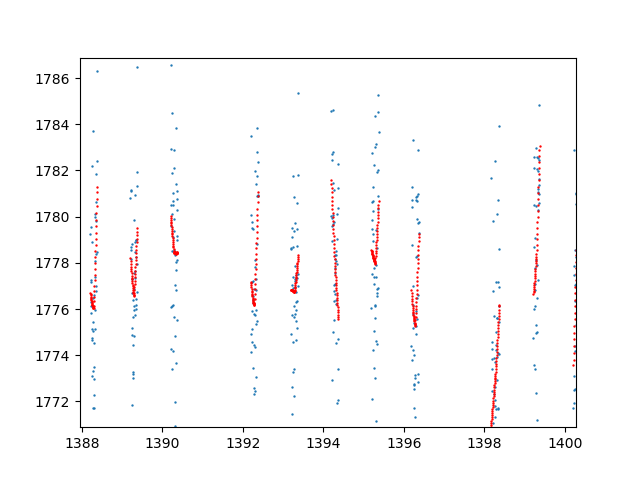

In [31]:
window_length = 6/24

flatten_lc, trend_lc = flatten(
        time,                 # Array of time values
        flux_transit,                 # Array of flux values
        method='lowess',
        window_length = window_length,# The length of the filter window in units of ``time``
#         break_tolerance = 0.7,
        return_trend=True,    # Return trend and flattened light curve
        )
%matplotlib notebook
plt.scatter(time, flux_transit, s = 0.5)
plt.scatter(time, trend_lc, s= 0.5, color = 'red')
# plt.ylim([215, 230])
# plt.xlim([1440, 1457])

# plt.scatter(time, flatten_lc, s = 0.5)
# plt.plot(time, synthetic_signal, color = 'orange')
# plt.ylim([0.9, 1.1])

In [ ]:
# Looping over the window_lengths written in hours and converted

output = pd.DataFrame()

for i in np.linspace(1, 3, 5): 
    w_length = i
    
    flatten_lc, trend_lc = flatten(
        time,                 # Array of time values
        flux_transit,                 # Array of flux values
        method='lowess',
        window_length = w_length ,    # The length of the filter window in units of ``time``
        return_trend=True,    # Return trend and flattened light curve
        )
    
    time_flatten, flatten_lc = cleaned_array(time, flatten_lc)
        
    flux_sigma_clipped = sigma_clip(flatten_lc, sigma_lower = float('inf'), sigma_upper= 4)
    
    model = transitleastsquares(time_flatten, flux_sigma_clipped)
    results = model.power(period_min = 1, period_max = 10, limb_dark = 'linear', u =[0], use_threads = 40, oversampling_factor=2)
    output = output.append(results, ignore_index = True)
    

In [ ]:

# model = transitleastsquares(time, flux_sigma_clipped)
# results = model.power(period_min = 1, period_max = 10, limb_dark = 'linear', u =[0], use_threads = 4)
   
# results["obj_id"] = obj_ids[object_num]

output['period']

In [ ]:
plt.plot(results.periods, results.power)


In [ ]:
plt.scatter(time, flux)
plt.scatter(time2, flux_sigma_clipped)


In [3]:
from wotan import t14
tdur = t14(R_s=1, M_s=1, P=3)
print(tdur)

0.13097523423633856
